Saving Flower.jpeg to Flower.jpeg


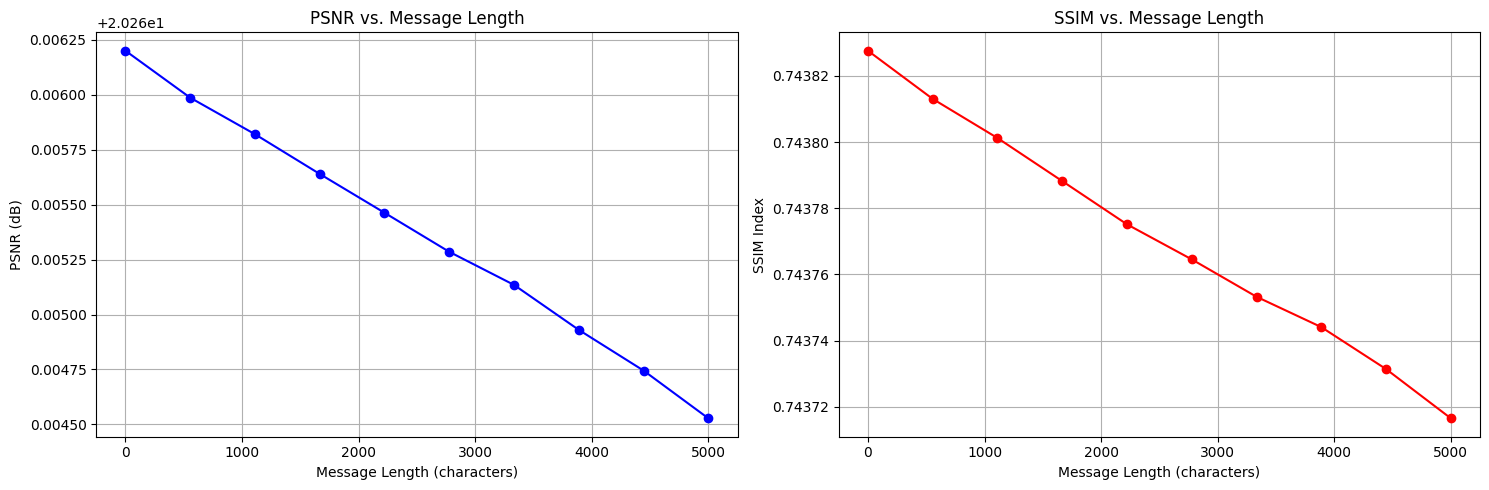

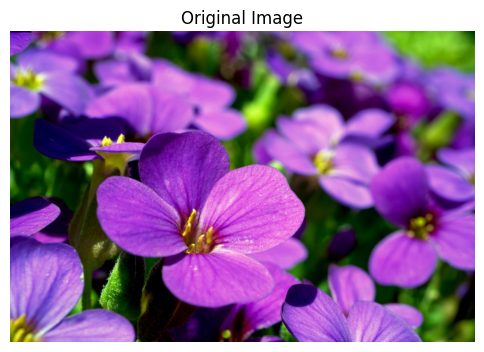

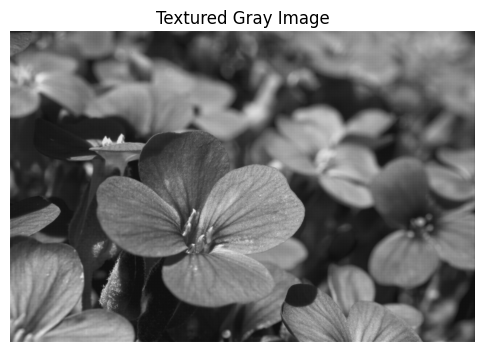

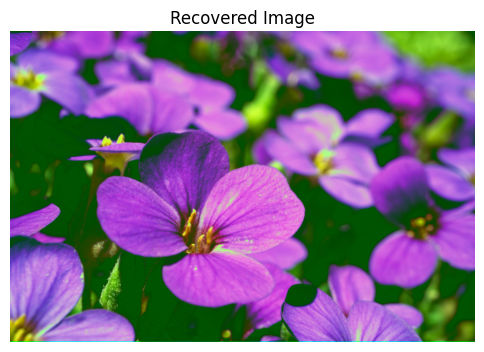

📈 PSNR between Original and Recovered: 20.27 dB
📊 SSIM between Original and Recovered: 0.7438
🔓 Enter the key to extract the hidden message: 11
🔍 Message Result: [ACCESS DENIED] Wrong key entered.


In [ ]:
!pip install opencv-python-headless pywavelets matplotlib scikit-image --quiet

import numpy as np
import cv2
import pywt
import random
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image
from io import BytesIO
import math
from skimage.metrics import structural_similarity as ssim

# Upload an image
uploaded = files.upload()
for fname in uploaded:
    img_pil = Image.open(BytesIO(uploaded[fname])).convert("RGB")
    img_rgb = np.array(img_pil)
    break

def show_image(img, title='', cmap=None):
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.title(title)
    plt.show()

# 📏 PSNR
def compute_psnr(original, recovered):
    mse = np.mean((original.astype(np.float32) - recovered.astype(np.float32)) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    return 20 * math.log10(max_pixel / math.sqrt(mse))

# 📏 SSIM
def compute_ssim(original, recovered):
    h, w = original.shape[:2]
    min_dim = min(h, w)
    win_size = 7 if min_dim >= 7 else (min_dim // 2) * 2 + 1  # Ensure it's odd and fits
    ssim_value, _ = ssim(original, recovered, full=True, channel_axis=-1, win_size=win_size)
    return ssim_value

def color_to_textured_gray_fixed(img_rgb, message=None):
    img_ycc = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2YCrCb)
    Y, Cr, Cb = cv2.split(img_ycc)

    coeffs = pywt.wavedec2(Y, 'haar', level=2)
    LL2, (LH2, HL2, HH2), (LH1, HL1, HH1) = coeffs

    shape = LH2.shape
    Cr_resized = cv2.resize(Cr, (shape[1], shape[0]), interpolation=cv2.INTER_AREA)
    Cb_resized = cv2.resize(Cb, (shape[1], shape[0]), interpolation=cv2.INTER_AREA)

    LH2_embedded = Cr_resized.astype(np.float32)
    HL2_embedded = Cb_resized.astype(np.float32)

    coeffs_embedded = (LL2, (LH2_embedded, HL2_embedded, HH2), (LH1, HL1, HH1))
    textured_gray = pywt.waverec2(coeffs_embedded, 'haar')
    textured_gray = np.clip(textured_gray, 0, 255).astype(np.uint8)

    return textured_gray

def embed_message_in_pixels_with_key(img_gray, message, key):
    img_uint8 = np.round(np.clip(img_gray, 0, 255)).astype(np.uint8)
    flat = img_uint8.flatten()

    message_bin = ''.join(f'{ord(c):08b}' for c in message)
    length_bin = f'{len(message_bin):032b}'  # 32 bits to store message length
    full_message = length_bin + message_bin

    if len(full_message) > len(flat):
        raise ValueError("Message too long to embed in image.")

    random.seed(key)
    indices = list(range(len(flat)))
    random.shuffle(indices)

    for i in range(len(full_message)):
        idx = indices[i]
        flat[idx] = (int(flat[idx]) & ~1) | int(full_message[i])

    return flat.reshape(img_uint8.shape)

def extract_message_from_pixels_with_key(img_gray, key):
    flat = np.round(np.clip(img_gray, 0, 255)).astype(np.uint8).flatten()

    random.seed(key)
    indices = list(range(len(flat)))
    random.shuffle(indices)

    length_bits = [str(flat[indices[i]] & 1) for i in range(32)]
    length = int(''.join(length_bits), 2)

    if length <= 0 or 32 + length > len(flat):
        return "[ERROR] Corrupted or missing message."

    message_bits = [str(flat[indices[i]] & 1) for i in range(32, 32 + length)]
    message = ''
    for i in range(0, len(message_bits), 8):
        byte = ''.join(message_bits[i:i+8])
        message += chr(int(byte, 2))
    return message

def textured_gray_to_color_fixed(gray_img, original_shape, recover_message=False):
    coeffs = pywt.wavedec2(gray_img, 'haar', level=2)
    LL2, (LH2, HL2, HH2), (LH1, HL1, HH1) = coeffs

    Cr_resized = np.clip(LH2, 0, 255).astype(np.uint8)
    Cb_resized = np.clip(HL2, 0, 255).astype(np.uint8)

    h, w = original_shape[:2]
    Cr = cv2.resize(Cr_resized, (w, h), interpolation=cv2.INTER_CUBIC)
    Cb = cv2.resize(Cb_resized, (w, h), interpolation=cv2.INTER_CUBIC)

    zero_band = np.zeros_like(HL2)
    coeffs_clean = (LL2, (zero_band, zero_band, HH2), (LH1, HL1, HH1))
    Y_restored = pywt.waverec2(coeffs_clean, 'haar')
    Y_restored = np.clip(Y_restored, 0, 255).astype(np.uint8)

    img_ycc = cv2.merge((Y_restored, Cr, Cb))
    img_rgb_restored = cv2.cvtColor(img_ycc, cv2.COLOR_YCrCb2RGB)

    recovered_message = None
    if recover_message:
        recovered_message = extract_message_from_pixels_with_key(gray_img)

    return img_rgb_restored, recovered_message


secret_message = "this is top secret"
secret_key = 123456

# 📈 PSNR & SSIM vs. Message Length Graph
def simulate_metrics_vs_message_length(img_rgb, key, steps=10, max_chars=5000):
    message_lengths = np.linspace(0, max_chars, steps, dtype=int)
    psnr_values = []
    ssim_values = []

    for length in message_lengths:
        message = 'a' * length  # create dummy message of specific length
        gray_img = color_to_textured_gray_fixed(img_rgb)
        try:
            gray_img_with_msg = embed_message_in_pixels_with_key(gray_img, message, key)
            recovered_img, _ = textured_gray_to_color_fixed(gray_img_with_msg, img_rgb.shape)
            psnr = compute_psnr(img_rgb, recovered_img)
            ssim_val = compute_ssim(img_rgb, recovered_img)
        except ValueError:
            psnr = None  # too much message to embed
            ssim_val = None
        psnr_values.append(psnr)
        ssim_values.append(ssim_val)

    return message_lengths, psnr_values, ssim_values

# Run and plot both metrics
message_lengths, psnr_values, ssim_values = simulate_metrics_vs_message_length(img_rgb, secret_key, steps=10, max_chars=5000)

# Create figure with two subplots
plt.figure(figsize=(15, 5))

# PSNR plot
plt.subplot(1, 2, 1)
plt.plot(message_lengths, psnr_values, marker='o', linestyle='-', color='blue')
plt.title('PSNR vs. Message Length')
plt.xlabel('Message Length (characters)')
plt.ylabel('PSNR (dB)')
plt.grid(True)

# SSIM plot
plt.subplot(1, 2, 2)
plt.plot(message_lengths, ssim_values, marker='o', linestyle='-', color='red')
plt.title('SSIM vs. Message Length')
plt.xlabel('Message Length (characters)')
plt.ylabel('SSIM Index')
plt.grid(True)

plt.tight_layout()
plt.show()


# 🔐 Hardcoded secret message and key
secret_message = """ This is a secured message. """
#secret_key = 123456


# Step 1: Convert color to textured gray
gray_img = color_to_textured_gray_fixed(img_rgb)

# Step 2: Embed message
gray_img = embed_message_in_pixels_with_key(gray_img, secret_message, secret_key)

# Step 3: Recover color image
recovered_img, _ = textured_gray_to_color_fixed(gray_img, img_rgb.shape)

# Step 4: Show images
show_image(img_rgb, 'Original Image')
show_image(gray_img, 'Textured Gray Image', cmap='gray')
show_image(recovered_img, 'Recovered Image')

# Step 5: Compute metrics
psnr_value = compute_psnr(img_rgb, recovered_img)
ssim_value = compute_ssim(img_rgb, recovered_img)
print(f"📈 PSNR between Original and Recovered: {psnr_value:.2f} dB")
print(f"📊 SSIM between Original and Recovered: {ssim_value:.4f}")


# Step 6: Ask for key and extract message
read_key = int(input("🔓 Enter the key to extract the hidden message: "))
if read_key == secret_key:
    recovered_message = extract_message_from_pixels_with_key(gray_img, read_key)
else:
    recovered_message = "[ACCESS DENIED] Wrong key entered."
# Final output
print("🔍 Message Result:", recovered_message)
